# <h1><center>Heart Attack Dataset -- Modeling</center></h1>

### <center>By: Hio Wa Mak</center>

# Import Packages

In [1]:
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from scipy.stats import uniform 
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import SMOTE
from sklearn import __version__ as sklearn_version
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
import statsmodels.api as sm 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Read in the Data

In [2]:
# Read CSV files into DataFrames
X_train_scaled_df = pd.read_csv('../data/X_train_scaled.csv')
X_test_scaled_df = pd.read_csv('../data/X_test_scaled.csv')
y_train_df = pd.read_csv('../data/y_train.csv')
y_test_df = pd.read_csv('../data/y_test.csv')
X = pd.read_csv('../data/X.csv')

# Convert DataFrames to Numpy arrays
X_train= X_train_scaled_df.values
X_test = X_test_scaled_df.values
y_train = y_train_df.values.ravel()
y_test = y_test_df.values.ravel()

# Dealing with Imbalanced data

In the Heart Attack dataset, the target variable `HadHeartAttack` is highly imbalanced, with 94% of participants not having experienced a heart attack. To improve classification performance and ensure the results generalize well to the testing data, I will explore several methods for addressing this imbalance.

The strategies include:
1. Using evaluation metrics better suited for imbalanced datasets, such as precision, recall, and F1-score, rather than relying on accuracy alone. Recall is particularly crucial, as the goal is to minimize false negatives (failing to detect individuals who have had a heart attack).
2. Applying class weights to the models to adjust for the imbalance, ensuring that the minority class (those who had a heart attack) is given more importance during training.

# Modeling

## Logistic Regression

Let's fit a regular logistic regression model using randomized search cross-validation, and accuracy as scoring criterion

In [3]:
# Fit a logistic regression model

# Define parameters for randomized search
param_distributions = {
    'C': uniform(0.001, 100),  # Uniform distribution for C, ranges from 0.001 to 100
    'penalty': ['l1', 'l2'],   # Regularization type (L1 = Lasso, L2 = Ridge)
    'solver': ['liblinear', 'saga']  # Solvers that support L1 and L2
}

# Set up the logistic regression model
logreg = LogisticRegression()

# Perform randomized search with 10 iterations and 5-fold cross-validation
logreg_random = RandomizedSearchCV(estimator = logreg, 
                                   param_distributions = param_distributions, 
                                   n_iter=20, 
                                   cv=5, 
                                   scoring='accuracy', 
                                   random_state=42, 
                                   verbose=1,
                                   n_jobs=-1)

# Time the fitting process
start_time = time.time()
logreg_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Estimation time: 14.22 minutes


In [4]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(logreg_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[322946   3582]
 [ 15045   4674]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    326528
           1       0.57      0.24      0.33     19719

    accuracy                           0.95    346247
   macro avg       0.76      0.61      0.65    346247
weighted avg       0.93      0.95      0.94    346247



While the accuracy score is high at 0.95, the recall for the positive class is significantly lower at 0.24. In the case of imbalanced data, recall is a more critical metric than accuracy, especially when the goal is to minimize false negatives.

## Logistic Regression

### Add 'class_weight' as hyperparameter and use 'recall' as evaluation metric for cross validation

In [5]:
# Since we have unbalanced design, let's do this again using class_weight as a hyperparameter for tuning 
# And using "recall" as the main evaluation metric

# Fit a logistic regression model
# Define parameters for randomized search
param_distributions = {
    'C': uniform(0.001, 100),  # Uniform distribution for C, ranges from 0.001 to 100
    'penalty': ['l1', 'l2'],   # Regularization type (L1 = Lasso, L2 = Ridge)
    'solver': ['liblinear', 'saga'],  # Solvers that support L1 and L2
    'class_weight': [None, 'balanced']
}

# Set up the logistic regression model
logreg = LogisticRegression()

# Perform randomized search with 10 iterations and 5-fold cross-validation
logreg_random = RandomizedSearchCV(estimator = logreg, 
                                   param_distributions = param_distributions, 
                                   n_iter=20, # Number of different combinations to try
                                   cv=5, 
                                   scoring='recall', 
                                   random_state=42, 
                                   verbose=1,
                                   n_jobs=-1) # Use all available cores (8)

# Time the fitting process
start_time = time.time()
logreg_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters
print("Best hyperparameters found:", logreg_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Estimation time: 8.44 minutes
Best hyperparameters found: {'C': 33.371861113902185, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


In [6]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(logreg_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
logreg_class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nLogistic Regression Classification Report:")
print(logreg_class_report)

Confusion Matrix:
[[272373  54155]
 [  4638  15081]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90    326528
           1       0.22      0.76      0.34     19719

    accuracy                           0.83    346247
   macro avg       0.60      0.80      0.62    346247
weighted avg       0.94      0.83      0.87    346247



In [7]:
# Examine feature coefficient from the best model
coefficients = logreg_random.best_estimator_.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# The top 20 features
print(feature_importance[0:20])

                    Feature  Coefficient  Abs_Coefficient
25              AgeCategory     0.707942         0.707942
7                 HadAngina     0.591795         0.591795
27                   Female    -0.334749         0.334749
3           LastCheckupTime    -0.292839         0.292839
24                ChestScan     0.234134         0.234134
8                 HadStroke     0.231545         0.231545
6              RemovedTeeth     0.167005         0.167005
22             SmokerStatus     0.131649         0.131649
15              HadDiabetes     0.131207         0.131207
4        PhysicalActivities    -0.076401         0.076401
11                  HadCOPD     0.060892         0.060892
26          AlcoholDrinkers    -0.053241         0.053241
13         HadKidneyDisease     0.051079         0.051079
28              BMICategory     0.049138         0.049138
0             GeneralHealth    -0.045225         0.045225
34                 Colorado     0.041456         0.041456
17  BlindOrVis

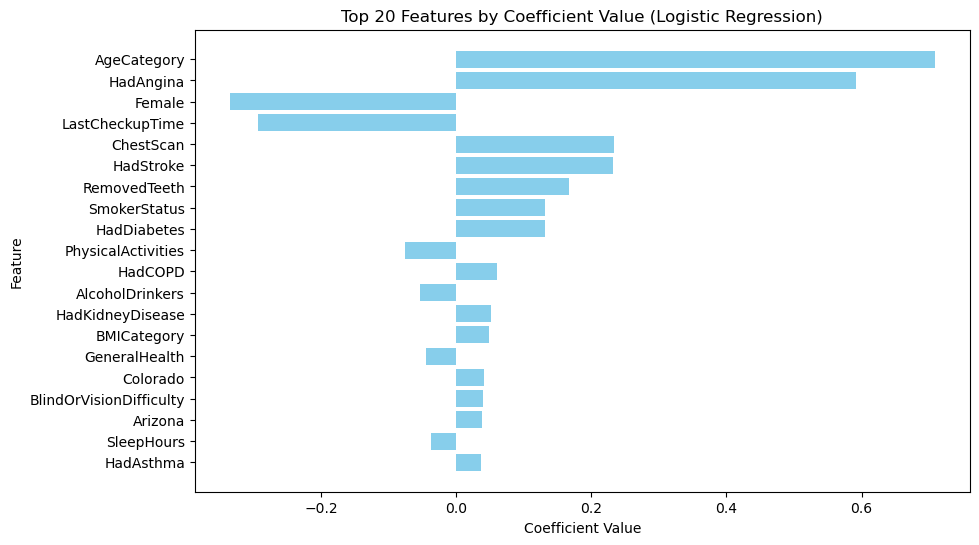

In [8]:
# Plot the top 20 features based on absolute coefficient values
top_20_features = feature_importance.head(20)  # Select the top 20 features

plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'], color='skyblue')  # Horizontal bar plot
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Features by Coefficient Value (Logistic Regression)')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest feature at the top
plt.show()

## Random Forest

Tree-based models can be a good choice for imbalanced data. Let's fit a random forest model.

In [9]:
# Fit a random forest model

# Define parameters for randomized search

param_dist = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'class_weight': [None, 'balanced']
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
}

# Set up the random forest model
rf = RandomForestClassifier(random_state=42)

# Setup the RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=param_dist,
                               n_iter=20,  
                               cv=5, 
                               scoring="recall",
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)  

# Time the fitting process
start_time = time.time()
rf_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters
print("Best hyperparameters found:", rf_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Estimation time: 79.94 minutes
Best hyperparameters found: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}


In [10]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(rf_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
rf_class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nRandom Forest Classification Report:")
print(rf_class_report)

Confusion Matrix:
[[265230  61298]
 [  4321  15398]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89    326528
           1       0.20      0.78      0.32     19719

    accuracy                           0.81    346247
   macro avg       0.59      0.80      0.60    346247
weighted avg       0.94      0.81      0.86    346247



In [11]:
#TN, FP, FN, TP = conf_matrix.ravel()
#print(f'accuracy: {(TP + TN)/(TP + TN + FP + FN):.4f}')
#print(f'precision: {TP/(TP+ FP):.4f}')
#print(f'recall: {TP/(TP+ FN):.4f}')
#print(f'f1-score: {2*TP/(2*TP+ FP+ FN):.4f}')

In [12]:
# Examine feature coefficient from the best model
importances = rf_random.best_estimator_.feature_importances_  # Get feature importances

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 20 most important features
print(feature_importance_df.head(20))

                Feature  Importance
7             HadAngina    0.291904
25          AgeCategory    0.140246
24            ChestScan    0.079703
3       LastCheckupTime    0.066297
6          RemovedTeeth    0.055570
19    DifficultyWalking    0.044730
8             HadStroke    0.043432
15          HadDiabetes    0.037931
14         HadArthritis    0.030979
1    PhysicalHealthDays    0.023853
11              HadCOPD    0.023411
27               Female    0.021477
22         SmokerStatus    0.020051
16  DeafOrHardOfHearing    0.014595
5            SleepHours    0.012178
4    PhysicalActivities    0.011619
13     HadKidneyDisease    0.011372
26      AlcoholDrinkers    0.007027
0         GeneralHealth    0.006519
21    DifficultyErrands    0.005905


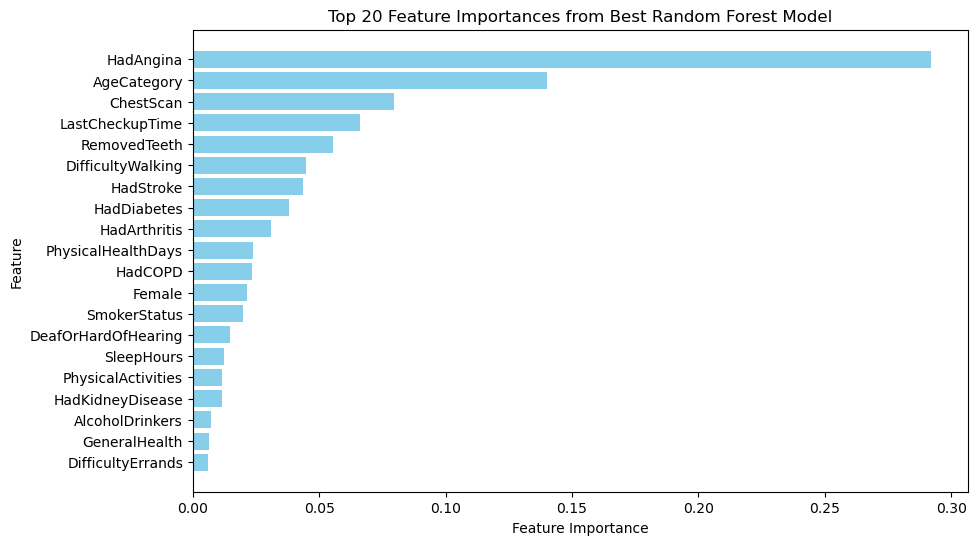

In [13]:
# Select the top 20 most important features
top_20_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.show()

## Extreme Gradient Boosting (XGBoost)

XGBoost is a boosting ensemble method that trains models sequentially. It is particularly effective at handling imbalanced data.

In [14]:
# Define the parameter grid for XGBoost
param_distributions = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [3, 5, 7, 10],      # Maximum depth of trees
    'min_child_weight': [1, 3, 5, 7],  # Minimum sum of weights in a child node
    'subsample': [0.7, 0.8, 1.0],    # Subsample ratio
    'colsample_bytree': [0.7, 0.8, 1.0], # Fraction of features to be used for each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'gamma': [0, 0.1, 0.2],           # Minimum loss reduction
    'reg_alpha': [0, 0.1, 1],         # L1 regularization term
    'reg_lambda': [1, 1.5, 2],         # L2 regularization term
    'scale_pos_weight': [10, 15.7, 20]  # Handling imbalanced data
}

# Set up the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Perform randomized search with 10 iterations and 5-fold cross-validation
xgb_random = RandomizedSearchCV(estimator=xgb, 
                                param_distributions=param_distributions, 
                                n_iter=20,  
                                cv=5,       
                                scoring='recall', 
                                random_state=42, 
                                verbose=1, 
                                n_jobs=-1)

# Time the fitting process
start_time = time.time()
xgb_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters found by RandomizedSearchCV
print("Best hyperparameters found:", xgb_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Estimation time: 6.79 minutes
Best hyperparameters found: {'subsample': 0.7, 'scale_pos_weight': 20, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}


In [15]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(xgb_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
xgb_class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nXGBoost Classification Report:")
print(xgb_class_report)

Confusion Matrix:
[[244586  81942]
 [  3128  16591]]

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85    326528
           1       0.17      0.84      0.28     19719

    accuracy                           0.75    346247
   macro avg       0.58      0.80      0.57    346247
weighted avg       0.94      0.75      0.82    346247



## Naïve Bayes

### Gaussian Naïve Bayes

In [16]:
# Treating features as continuous, use GaussianNB
# Define parameters for randomized search for Naive Bayes (GaussianNB)
param_dist = {
    'var_smoothing': [1e-12, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4] # Variance smoothing parameter for GaussianNB
}

# Set up the Gaussian Naive Bayes model
gnb = GaussianNB()

# Setup the RandomizedSearchCV
nb_random = RandomizedSearchCV(estimator=gnb,
                               param_distributions=param_dist,
                               n_iter=8,  # covers all possible trials, which is equal to GridSearchCV in this case
                               cv=5,  # Number of cross-validation folds
                               scoring="recall",
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)  # Use all available cores

# Time the fitting process
start_time = time.time()
nb_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters
print("Best hyperparameters found:", nb_random.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Estimation time: 0.17 minutes
Best hyperparameters found: {'var_smoothing': 1e-12}


In [17]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(nb_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
nb_class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nNaïve Bayes Classification Report:")
print(nb_class_report)

Confusion Matrix:
[[266989  59539]
 [  5780  13939]]

Naïve Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89    326528
           1       0.19      0.71      0.30     19719

    accuracy                           0.81    346247
   macro avg       0.58      0.76      0.60    346247
weighted avg       0.93      0.81      0.86    346247



## Model Selection

Given the imbalanced data, I use the recall score for the positive class and macro average of the recall scores across classes for selecting the best model. Here is the comparison for the four models:
1. Logistic regression: recall(1) = 0.76; recall(avg) = 0.80
2. Random forest: recall(1) = 0.78; recall(avg) = 0.80
3. XGBoost: recall(1) = 0.84; recall(avg) = 0.80
4. Naive Bayes: recall(1) = 0.71; recall(avg) = 0.76

In [18]:
print("\nLogistic Regression Classification Report:")
print(logreg_class_report)

print("\nRandom Forest Classification Report:")
print(rf_class_report)

print("\nXGBoost Classification Report:")
print(xgb_class_report)

print("\nNaïve Bayes Classification Report:")
print(nb_class_report)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90    326528
           1       0.22      0.76      0.34     19719

    accuracy                           0.83    346247
   macro avg       0.60      0.80      0.62    346247
weighted avg       0.94      0.83      0.87    346247


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89    326528
           1       0.20      0.78      0.32     19719

    accuracy                           0.81    346247
   macro avg       0.59      0.80      0.60    346247
weighted avg       0.94      0.81      0.86    346247


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85    326528
           1       0.17      0.84      0.28     19719

    accuracy                           0.75    346247
   macro avg  

Therefore, XGBoost is our best model.

### Examine Feature Importance

In [19]:
# Examine feature importance for the best model
importances = xgb_random.best_estimator_.feature_importances_  # Get feature importances

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 20 most important features
print(feature_importance_df.head(20))

                    Feature  Importance
7                 HadAngina    0.848644
24                ChestScan    0.026139
25              AgeCategory    0.023477
3           LastCheckupTime    0.018112
8                 HadStroke    0.013602
19        DifficultyWalking    0.012884
6              RemovedTeeth    0.006172
14             HadArthritis    0.005534
27                   Female    0.005035
15              HadDiabetes    0.004349
11                  HadCOPD    0.003065
16      DeafOrHardOfHearing    0.003063
22             SmokerStatus    0.001646
17  BlindOrVisionDifficulty    0.001528
13         HadKidneyDisease    0.001284
21        DifficultyErrands    0.001270
4        PhysicalActivities    0.001266
1        PhysicalHealthDays    0.001246
0             GeneralHealth    0.000876
5                SleepHours    0.000777


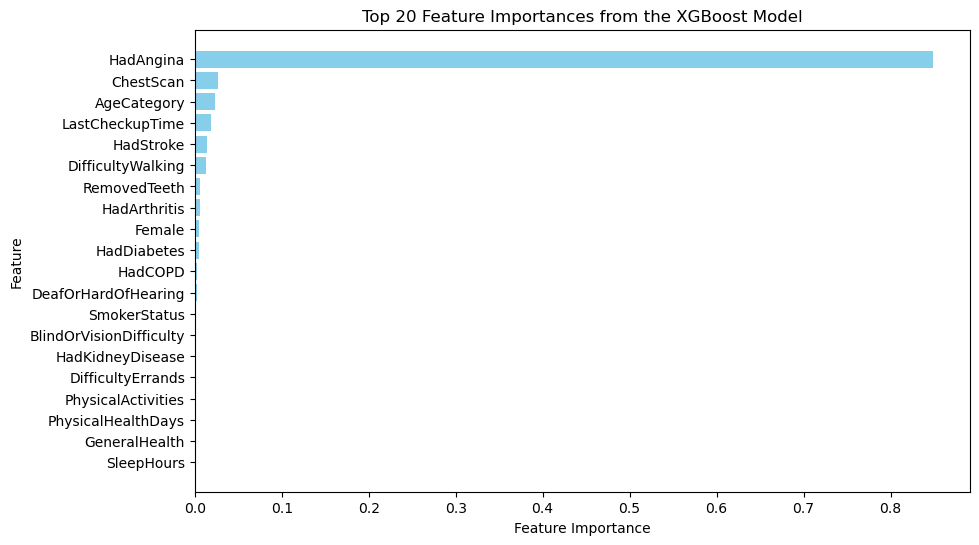

In [20]:
# Select the top 20 most important features
top_20_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from the XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.show()

### A Note on Feature Importance

Interpreting feature importance in Logistic Regression differs from that in tree-based models like Random Forest and XGBoost. In Logistic Regression, feature importance is represented by coefficients, which indicate both the strength and the direction of a feature’s influence on the outcome. A positive coefficient increases the likelihood of the positive class, while a negative coefficient decreases it, making the coefficients directly interpretable.

In contrast, feature importance in tree-based models (like Random Forest and XGBoost) indicates the relative contribution of each feature to the model’s performance, based on how much the feature improves the splits in the decision trees. These importance scores measure how much each feature helps to reduce the loss or improve accuracy but do not convey directionality (positive or negative).

Therefore, while Logistic Regression coefficients are more interpretable in terms of understanding the relationship between features and the outcome, feature importance in tree-based models reflects a feature's overall usefulness in predicting the outcome but lacks direct interpretability regarding the direction of the influence.

## Model Evaluation Using Testing Data

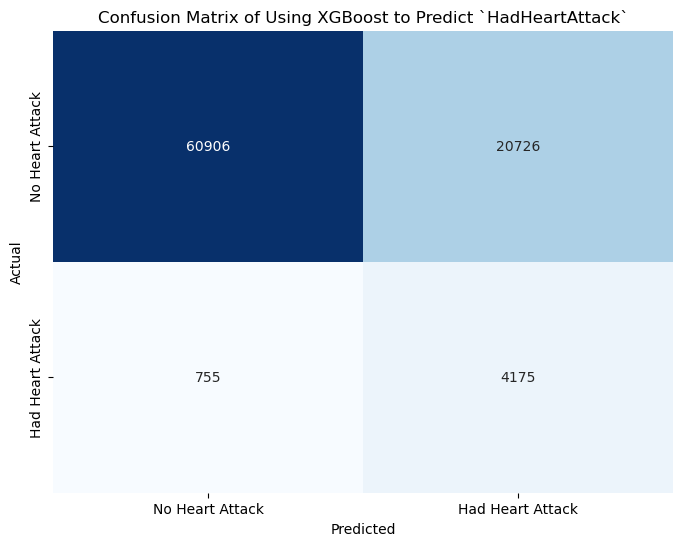

In [21]:
# Evaluate on the test set
y_pred = xgb_random.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate the classification report
class_report = classification_report(y_test, y_pred)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=['No Heart Attack', 'Had Heart Attack'], 
            yticklabels=['No Heart Attack', 'Had Heart Attack'])
plt.title('Confusion Matrix of Using XGBoost to Predict `HadHeartAttack`')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
print("\nXGBoosting Classification Report on Testing Data:")
print(class_report)


XGBoosting Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     81632
           1       0.17      0.85      0.28      4930

    accuracy                           0.75     86562
   macro avg       0.58      0.80      0.57     86562
weighted avg       0.94      0.75      0.82     86562



## Refit the Final Model on All Available Data

In [23]:
# Initialize a new XGBoost model using the best parameters
final_model = XGBClassifier(
    n_estimators=xgb_random.best_params_['n_estimators'],
    max_depth=xgb_random.best_params_['max_depth'],
    min_child_weight=xgb_random.best_params_['min_child_weight'],
    subsample=xgb_random.best_params_['subsample'],
    colsample_bytree=xgb_random.best_params_['colsample_bytree'],
    learning_rate=xgb_random.best_params_['learning_rate'],
    gamma=xgb_random.best_params_['gamma'],
    reg_alpha=xgb_random.best_params_['reg_alpha'],
    reg_lambda=xgb_random.best_params_['reg_lambda'],
    scale_pos_weight=xgb_random.best_params_['scale_pos_weight'],
    random_state=42  # Keep the random state for reproducibility
)

# Combine the training, validation, and testing sets for final training
X_final = pd.concat([X_train_scaled_df, X_test_scaled_df], axis=0)
y_final = pd.concat([y_train_df, y_test_df], axis=0)

# Fit the final model on the entire dataset (training + validation + testing)
start_time = time.time()
final_model.fit(X_final, y_final)
end_time = time.time()
final_est_time = (end_time - start_time)

# Print the final training time
print(f"Final model training time: {final_est_time/60:.2f} minutes")

Final model training time: 0.08 minutes


## Save the Final Model

In [24]:
# Get details of the final model
best_model = final_model
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X.columns]
best_model.build_datetime = datetime.datetime.now()

# Set up the path where the model will be saved
modelpath = '../models'
if not os.path.exists(modelpath):
    os.makedirs(modelpath)
    
# Save the model to the specified file path (useful for future deployment)
filepath = os.path.join(modelpath, 'heart_attack_xgboost_model.pkl')
with open(filepath, 'wb') as f:
    pickle.dump(best_model, f)

## Summary

In this modeling stage, the primary objective is to identify the best classifier and optimal model parameters to predict whether an individual has had a heart attack. The process involves the following steps:

1. Run multiple models (Logistic Regression, Random Forest, XGBoost, and Naive Bayes) and use cross-validation to fine-tune hyperparameters.
2. Evaluate the models using metrics such as accuracy, precision, recall, and F1-score.
3. Select the best model based on recall (sensitivity), prioritizing the minimization of false negatives — the risk of incorrectly identifying a person as not having had a heart attack when they actually have.
4. Analyze the feature importance of the final model.
5. Assess the model’s performance on the test set.
6. Refit the best model using the entire dataset.
7. Save the final model for future use.

Given the imbalanced nature of the data (94% of participants did not experience a heart attack), specific strategies were employed to address this challenge. First, recall was chosen as the primary scoring criterion for cross-validation and final model selection to prioritize sensitivity. Second, class weights were added as a hyperparameter to help the model better account for the imbalance. Importantly, oversampling and undersampling techniques were not used, as the imbalance reflects the natural prevalence of heart attacks in the population, not a selection bias. Applying these techniques could lead to overfitting on the training data, reducing generalization to the test data.

Among all the models, XGBoost performed the best, achieving the highest recall for the positive class (0.84) and a macro-average recall of 0.80. While precision and F1-scores were relatively low (ranging from 0.17 to 0.34 for the positive class), this was expected due to the data imbalance and the focus on optimizing recall. Feature importance analysis highlighted `HadAngina`, `ChestScan`, `AgeCategory`, `LastCheckUpTime`, `HadStroke`, and `DifficultyWalking` as the key predictors in this model. When evaluated on the test data, the model’s accuracy, precision, recall, and F1-score closely matched the training results, indicating strong generalization to unseen data. Lastly, the model was refitted on the entire dataset using the optimal hyperparameters, and the final model was saved for future deployment.